# Creating HDF store
This script creates an HDF5 file based on the data from previous steps. The HDF5 file enables training on a large data set.

In [1]:
import numpy as np
import pandas as pd

from sklearn.utils import shuffle

import h5py
from pathlib import Path

from datetime import datetime
import os
import re

from IPython import display
import math
from skimage import measure

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PICKLE_DATA_PATH = "./data/pickles/"
CONDITION_DATA_PATH = "./data/condition/"
HDF5_PATH = "./data/data.hdf5"

In [3]:
def log(s):
    with open("status_PY04_pdToHdf.txt", "a") as myfile:
        myfile.write("[" + str(datetime.now()) + "] " + s + "\n")
    print("[" + str(datetime.now()) + "] " + s)

In [4]:
def drop_nan_rows(df):
    # remove all frames in which no data about the fingernails are available
    return df.dropna(subset=["Thumb_Fn_X", "Index_Fn_X", "Middle_Fn_X", "Ring_Fn_X", "Little_Fn_X", "Phone_X"])

In [5]:
def errorneous_removal_heuristics(df):
    df1 = df[["Phone_X_Rotation", "Phone_Y_Rotation", "Phone_Z_Rotation", "Phone_W_Rotation"]]
    x = df1[df1.columns[0]]
    y = df1[df1.columns[1]]
    z = df1[df1.columns[2]]
    w = df1[df1.columns[3]]

    rot_matrix = np.array([
        [1-2*y*y-2*z*z, 2*x*y+2*w*z, 2*x*z - 2*w*y],
        [2*x*y - 2*w*z, 1-2*x*x-2*z*z, 2*y*z+2*w*x],
        [2*x*z+2*w*y, 2*y*z-2*w*x, 1-2*x*x-2*y*y]])

    angle = np.degrees(np.arccos(np.dot((rot_matrix[:,1,:].T), [0, 1, 0])))
    adf = pd.DataFrame(angle)
    df2 = adf[np.logical_not(adf[0].isnull())]
    df3 = df2[df2[0] < df2[0].mean() + df2[0].std()*4]
    dfFinal = df.iloc[df3.index]
    
    return dfFinal

In [6]:
def add_to_hdf(hdf, df, set_name):
    groupName = set_name
    pGroup = None
    groupExists = "/" + groupName in hdf

    if not (groupExists):
        pGroup = hdf.create_group(groupName)
    else:
        pGroup = hdf["/" + groupName]

    log("P" + str(i) + ": Drop nan/errorneous rows.")
    df = drop_nan_rows(df)
    df = errorneous_removal_heuristics(df)
    df = shuffle(df)
    
    # Get Images
    img_vals = df.MatrixMerged.apply(lambda x : x.flatten())
    
    # remove negative values 
    img_vals = df.MatrixMerged.apply(lambda x : x.clip(min=0))
    
    images = np.vstack(img_vals.values)
    images = images.reshape([-1, 28, 32, 1])

    # get labels
    label_vals = np.array(df[["Thumb_Fn_X", "Thumb_Fn_Y", "Thumb_Fn_Z", "Index_Fn_X", "Index_Fn_Y", "Index_Fn_Z", "Middle_Fn_X", "Middle_Fn_Y", "Middle_Fn_Z", "Ring_Fn_X", "Ring_Fn_Y", "Ring_Fn_Z", "Little_Fn_X", "Little_Fn_Y", "Little_Fn_Z"]])

    if not (groupExists):
        pGroup.create_dataset("images", data=images, maxshape=(None, 28, 32, 1), chunks=True)  
        pGroup.create_dataset("labels", data=label_vals, maxshape=(None, 15), chunks=True)
    else:
        pGroup["images"].resize((pGroup["images"].shape[0] + images.shape[0]), axis = 0)
        pGroup["images"][-images.shape[0]:] = images
        pGroup["labels"].resize((pGroup["labels"].shape[0] + label_vals.shape[0]), axis = 0)
        pGroup["labels"][-label_vals.shape[0]:] = label_vals        

# Creating HDF5 file

In [ ]:
if Path(HDF5_PATH).is_file():
    print("Open storage for appending.")
    hdf = h5py.File(HDF5_PATH, mode='a')
else:
    print("Creating new storage for writing.")
    hdf = h5py.File(HDF5_PATH, mode='w')            
        
training_participants = [2,3,4,5,6,11,12,13,14,15,16,17,20,21]
for i in training_participants:
    log("P" + str(i) + ": Reading dataframe for training.")
    df = pd.read_pickle("./data/pickles/corrected_data_with_bb_P" + str(i) + ".pkl")
    
    log("P" + str(i) + ": Adding to HDF.")
    add_to_hdf(hdf, df, "train")

test_participants = [8,9,10,19] # random pick from the list of participants
for i in test_participants:
    log("P" + str(i) + ": Reading dataframe for test.")
    df = pd.read_pickle("./data/pickles/corrected_data_with_bb_P" + str(i) + ".pkl")
    log("P" + str(i) + ": Adding to HDF.")
    add_to_hdf(hdf, df, "test")

validation_participants = [18,22] # random pick from the list of participants
for i in validation_participants:
    log("P" + str(i) + ": Reading dataframe for validation.")
    df = pd.read_pickle("./data/pickles/corrected_data_with_bb_P" + str(i) + ".pkl")
    log("P" + str(i) + ": Adding to HDF.")
    add_to_hdf(hdf, df, "validation")
    
hdf.close()

In [7]:
hdf = h5py.File(HDF5_PATH, mode='r')

In [14]:
print("Training samples:", hdf["train/images"].shape[0])
print("Test samples:", hdf["test/images"].shape[0])
print("Validation samples:", hdf["validation/images"].shape[0])
print("Total samples:", hdf["train/images"].shape[0]+hdf["test/images"].shape[0]+hdf["validation/images"].shape[0])

Training samples: 6402020
Test samples: 1962724
Validation samples: 1071159
Total samples: 9435903


# Video preview of capacitive images and OptiTrack Finger Positions

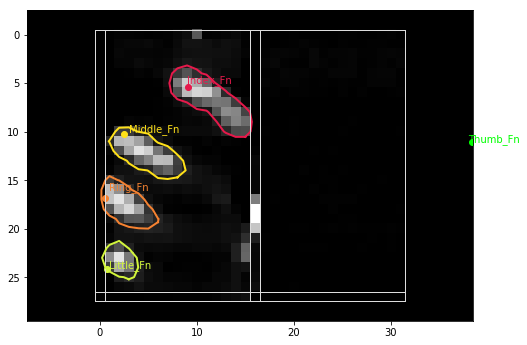

In [26]:
def getContour(img):
    contours = measure.find_contours(img, 35)
    results = []

    for n, contour in enumerate(contours):
        if (len(contour) > 5):
            results.append([contour[:, 1], contour[:, 0]])

    return results

finger_name = {
        -1: "-",
        0: "Thumb",
        1: "Index",
        2: "Middle",
        3: "Ring",
        4: "Little"
    }

def play_frames_with_opti(hdf, start_from):
    fig, ax = plt.subplots(1, figsize=(8, 6))
    count = start_from
    
    joints = ["Thumb_Fn", "Index_Fn", "Middle_Fn", "Ring_Fn", "Little_Fn"]
    colors = ["#00ff00", "#e6194b", "#ffe119", "#f58231", "#d2f53c"]

    ax.set_facecolor('black')        
    
    while count < hdf["train/images"].shape[0]:
        image = hdf["train/images"][count].reshape(28, 32)
        
        display.clear_output(wait=True)
        ax.cla()
        ax.imshow(image, interpolation="none", cmap="gray", vmin=0, vmax=255)
        
        ax.set_xlim([-7.5, 38.5])
        ax.set_ylim([29.5, -2.5])
        
        for marker in joints:
            x_loc = hdf["train/labels"][count][joints.index(marker) * 3] * 1000
            y_loc = hdf["train/labels"][count][joints.index(marker) * 3 + 1] * 1000
            x_loc = (15/62) * x_loc + 2  # 62mm screen width
            y_loc = (27/110) * y_loc + 2 # 110mm screen height
            
            # left edge
            plt.plot([0.5, 0.5], [-0.5, 27.5], '#DDDDDD', lw=1)
            plt.plot([-0.5, -0.5], [-0.5, 27.5], '#DDDDDD', lw=1)
            
            # right edge
            plt.plot([15.5, 15.5], [-0.5, 27.5], '#DDDDDD', lw=1)
            plt.plot([16.5, 16.5], [-0.5, 27.5], '#DDDDDD', lw=1)
            
            # bottom lines
            plt.plot([-0.5, 31.5], [26.5, 26.5], '#DDDDDD', lw=1)
            plt.plot([-0.5, 31.5], [27.5, 27.5], '#DDDDDD', lw=1)

            # front screen right
            plt.plot([31.5, 31.5], [-0.5, 27.5], '#DDDDDD', lw=1)    
            
            # top line
            plt.plot([-0.5, 31.5], [-0.5, -0.5], '#DDDDDD', lw=1)
            
            if (math.isnan(x_loc)):
                continue
            
            contours = getContour(image)

            for c in contours:
                color = '#ffffff'
                xoffset = 0
                
                if (marker == "Thumb_Fn"):
                    xoffset = 17
                
                if (x_loc+xoffset > c[0].min() and x_loc+xoffset < c[0].max()) and (y_loc > c[1].min() and y_loc < c[1].max()):
                    color = colors[joints.index(marker)]
                    ax.plot(c[0], c[1], color=color, linewidth=2)

            ax.scatter(x_loc+xoffset, y_loc, c=colors[joints.index(marker)])
            ax.text(round(x_loc+xoffset), round(y_loc - 0.5), marker, color=colors[joints.index(marker)])
        
        ax.grid("off")
        display.display(plt.gcf())
        count = count + 15


play_frames_with_opti(hdf, 0)  